# UVA CS 4710 HW4: Neural Networks

* Due: **4/21/2024** 23:59 PM
* (2 pt) *Your compute ID & Name: [wfs7bk] [Kevin Zhang]*

In this homework, you will implement the perceptron algorithm and a neural network to classify digits.

First, we will download the necessary files.

*   `nn.py`: Neural network mini-library.
*   `mnist.npz`: The dataset for digit classification.


In [ ]:
!gdown 1NdqfsLN4rPAn-JXDelGuR8wg2zt9a8si
!gdown 16IEo9QtRfaUYeyI3Tu2Nsw82aA_NG39D

Downloading...
From (original): https://drive.google.com/uc?id=1NdqfsLN4rPAn-JXDelGuR8wg2zt9a8si
From (redirected): https://drive.google.com/uc?id=1NdqfsLN4rPAn-JXDelGuR8wg2zt9a8si&confirm=t&uuid=9ee56f8d-56b4-4011-a2dd-01e10c88dd0e
To: /content/nn.py
100% 15.5k/15.5k [00:00<00:00, 60.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=16IEo9QtRfaUYeyI3Tu2Nsw82aA_NG39D
To: /content/mnist.npz
100% 18.5M/18.5M [00:00<00:00, 66.2MB/s]


## Provided Code (Part 1)

For this project, you have been provided with a neural network mini-library (`nn.py`).

The library in `nn.py` defines a collection of node objects. Each node represents a real number or a matrix of real numbers. Operations on node objects are optimized to work faster than using Python’s built-in types (such as lists).

Here are a few of the provided node types:

*   `nn.Constant` represents a matrix (2D array) of floating point numbers. It is typically used to represent input features or target outputs/labels. Instances of this type will be provided to you by other functions in the API; you will not need to construct them directly.
*   `nn.Parameter` represents a trainable parameter of a perceptron or neural network.
*   `nn.DotProduct` computes a dot product between its inputs.

Additional provided functions:

`nn.as_scalar` can extract a Python floating-point number from a node. When training a perceptron or neural network, you will be passed a dataset object. You can retrieve batches of training examples by calling dataset.iterate_once(batch_size):

```
for x, y in dataset.iterate_once(batch_size):
    ...
```

For example, let’s extract a batch of size 1 (i.e., a single training example) from the perceptron training data:

```
>>> batch_size = 1
>>> for x, y in dataset.iterate_once(batch_size):
...     print(x)
...     print(y)
...     break
...
<Constant shape=1x3 at 0x11a8856a0>
<Constant shape=1x1 at 0x11a89efd0>
```

The input features `x` and the correct label `y` are provided in the form of `nn.Constant` nodes. The shape of `x` will be `batch_size x num_features`, and the shape of `y` is `batch_size x num_outputs`. So, each row of `x` is a point/ sample, and a column is the same feature of some samples. Here is an example of computing a dot product of `x` with itself, first as a node and then as a Python number.

```
>>> nn.DotProduct(x, x)
<DotProduct shape=1x1 at 0x11a89edd8>
>>> nn.as_scalar(nn.DotProduct(x, x))
1.9756581717465536
```


Finally, here are some formulations of matrix multiplication (you can do some examples by hand to verify this). Let  𝐀  be an m×n matrix and $\mathbf{B} be `n×p`; matrix multiplication works as follows:
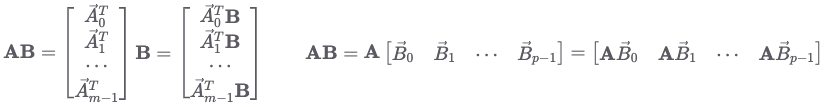


*   As a sanity check, the dimensions are what we expect them to be, and the inner dimension of $n$ is preserved for any remaining matrix multiplications.
*   This is useful to see what happens when we multiply a batch matrix $X$ by a weight matrix $W$, we are just multiplying each sample one at a time by the entire weight matrix via the first formulation. Within each sample times weights, we are just getting different linear combinations of the sample to go to each result column via the second formulation. Note that as long as the dimensiosn match,
$A$ can be a row vector and $B$ a column vector.

## Question 1 (38 pts): Perceptron

In this part, you will implement a binary perceptron. Your task will be to complete the implementation of the `PerceptronModel` class.

### Create the Perceptron Dataset

In order to test your binary perceptron implementation, we first create the `PerceptronDataset` class that contains the positive and negative data points. Using `iterate_once(batch_size)` method, you will be able to iterate the data to make updates.

* **NOTE**: We hide the following cells to save some space. Please remember to run them before testing your model. You can also unhide them to check out the implementation of a dataset.

In [ ]:
import time

import matplotlib.pyplot as plt
import numpy as np

import nn

In [ ]:
class Dataset(object):
    def __init__(self, x, y):
        assert isinstance(x, np.ndarray)
        assert isinstance(y, np.ndarray)
        assert np.issubdtype(x.dtype, np.floating)
        assert np.issubdtype(y.dtype, np.floating)
        assert x.ndim == 2
        assert y.ndim == 2
        assert x.shape[0] == y.shape[0]
        self.x = x
        self.y = y

    def iterate_once(self, batch_size):
        assert isinstance(batch_size, int) and batch_size > 0, (
            "Batch size should be a positive integer, got {!r}".format(
                batch_size))
        assert self.x.shape[0] % batch_size == 0, (
            "Dataset size {:d} is not divisible by batch size {:d}".format(
                self.x.shape[0], batch_size))
        index = 0
        while index < self.x.shape[0]:
            x = self.x[index:index + batch_size]
            y = self.y[index:index + batch_size]
            yield nn.Constant(x), nn.Constant(y)
            index += batch_size

    def iterate_forever(self, batch_size):
        while True:
            yield from self.iterate_once(batch_size)

    def get_validation_accuracy(self):
        raise NotImplementedError(
            "No validation data is available for this dataset. "
            "In this assignment, only the Digit Classification and Language "
            "Identification datasets have validation data.")

In [ ]:
from time import sleep
from IPython import display

class PerceptronDataset(Dataset):
    def __init__(self, model):
        points = 500
        x = np.hstack([np.random.randn(points, 2), np.ones((points, 1))])
        y = np.where(x[:, 0] + 2 * x[:, 1] - 1 >= 0, 1.0, -1.0)
        super().__init__(x, np.expand_dims(y, axis=1))

        self.model = model
        self.epoch = 0

        fig, ax = plt.subplots(1, 1)
        limits = np.array([-3.0, 3.0])
        ax.set_xlim(limits)
        ax.set_ylim(limits)
        positive = ax.scatter(*x[y == 1, :-1].T, color="red", marker="+")
        negative = ax.scatter(*x[y == -1, :-1].T, color="blue", marker="_")
        line, = ax.plot([], [], color="black")
        text = ax.text(0.03, 0.97, "", transform=ax.transAxes, va="top")
        ax.legend([positive, negative], [1, -1])
        #plt.show(block=False)
        display.display(plt.gcf())

        self.fig = fig
        self.limits = limits
        self.line = line
        self.text = text
        self.last_update = time.time()

    def iterate_once(self, batch_size):
        self.epoch += 1

        for i, (x, y) in enumerate(super().iterate_once(batch_size)):
            yield x, y

            if time.time() - self.last_update > 0.01:
                w = self.model.get_weights().data.flatten()
                limits = self.limits
                if w[1] != 0:
                    self.line.set_data(limits, (-w[0] * limits - w[2]) / w[1])
                elif w[0] != 0:
                    self.line.set_data(np.full(2, -w[2] / w[0]), limits)
                else:
                    self.line.set_data([], [])
                self.text.set_text(
                    "epoch: {:,}\npoint: {:,}/{:,}\nweights: {}".format(
                        self.epoch, i * batch_size + 1, len(self.x), w))
                #self.fig.canvas.draw_idle()
                #self.fig.canvas.start_event_loop(1e-3)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                self.last_update = time.time()

### Implement the Perceptron Model

For the perceptron, the output labels will be either `1` or `−1`, meaning that data points `(x, y)` from the dataset will have `y` be a `nn.Constant` node that contains either `1` or `−1` as its entries.

We have already initialized the perceptron weights `self.w` to be a `1` by dimensions parameter node. The provided code will include a bias feature inside `x` when needed, so you will not need a separate parameter for the bias.

Your tasks are to:

* Implement the `run(self, x)` method. This should compute the dot product of the stored weight vector and the given input, returning an nn.DotProduct object.
* Implement `get_prediction(self, x)`, which should return `1` if the dot product is non-negative or `−1` otherwise. You should use `nn.as_scalar` to convert a scalar Node into a Python floating-point number.
* Write the `train(self)` method. This should repeatedly loop over the data set and make updates on examples that are misclassified. Use the update method of the nn.Parameter class to update the weights. When an entire pass over the data set is completed without making any mistakes, 100% training accuracy has been achieved, and training can terminate.
* In this project, the only way to change the value of a parameter is by calling `parameter.update(direction, multiplier)`, which will perform the update to the weights:
\begin{equation}
  \text{weights ← weights + direction ⋅ multiplier}
\end{equation}

The `direction` argument is a `Node` with the same shape as the parameter, and the `multiplier` argument is a Python scalar. Additionally, use `iterate_once` to loop over the dataset; see [Provided Code (Part 1)](https://colab.research.google.com/drive/1YdKLZwO32KWhCK9KAdyz4fXIIxjIbBdv#scrollTo=3Zqs7m3buBOF&line=1&uniqifier=1) for usage.

In [ ]:
class PerceptronModel(object):
    def __init__(self, dimensions):
        self.w = nn.Parameter(1, dimensions)


    def get_weights(self):
        return self.w


    def run(self, x):
        return nn.DotProduct(self.w, x)


    def get_prediction(self, x):
        score = nn.as_scalar(self.run(x))
        return 1 if score >= 0 else -1


    def train(self, dataset):
        correct = False
        while not correct:
          correct = True
          for x, y in dataset.iterate_once(1):
            if nn.as_scalar(y) != self.get_prediction(x):
              self.w.update(x, nn.as_scalar(y))
              correct = False

To test your implementation, run the following cell. It will show the updated weights and the decision boundary.

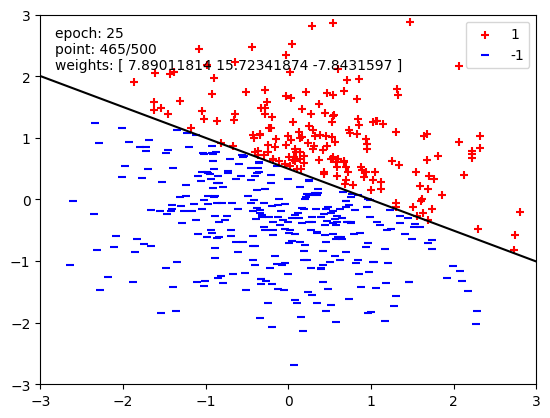

In [ ]:
model = PerceptronModel(3)
dataset = PerceptronDataset(model)
model.train(dataset)

## Provided Code (Part 2)

For the next question, you’ll use the framework provided in `nn.py` to create neural networks to solve the digit classification problem.

Here is a full list of nodes available in `nn.py`. You will make use of these in the remaining parts of the homework:

* `nn.Constant` represents a matrix (2D array) of floating point numbers. It is typically used to represent input features or target outputs/labels. Instances of this type will be provided to you by other functions in the API; you will not need to construct them directly.
* `nn.Parameter` represents a trainable parameter of a perceptron or neural network. All parameters must be 2-dimensional.
  * Usage: `nn.Parameter(n, m)` constructs a parameter with shape `n` by `m`.
* `nn.Add` adds matrices element-wise.
  * Usage: `nn.Add(x, y)` accepts two nodes of shape batch_size by num_features and constructs a node that also has shape `batch_size` by `num_features`.
* `nn.AddBias` adds a bias vector to each feature vector. Note: it automatically broadcasts the bias to add the same vector to every row of features.
  * Usage: `nn.AddBias(features, bias)` accepts features of shape `batch_size` by `num_features` and bias of shape `1` by `num_features`, and constructs a node that has shape `batch_size` by `num_features`.
* `nn.Linear` applies a linear transformation (matrix multiplication) to the input.
  * Usage: `nn.Linear(features, weights)` accepts features of shape `batch_size` by `num_input_features` and weights of shape `num_input_features` by `num_output_features`, and constructs a node that has shape `batch_size` by `num_output_features`.
* `nn.ReLU` applies the element-wise Rectified Linear Unit nonlinearity $relu(x)=max(x, 0)$. This nonlinearity replaces all negative entries in its input with zeros.
  * Usage: `nn.ReLU(features)`, which returns a node with the same shape as the input.
* `nn.SoftmaxLoss` computes a batched softmax loss, used for classification problems.
  * Usage: `nn.SoftmaxLoss(logits, labels)`, where `logits` and `labels` both have shape `batch_size` by `num_classes`. The term “logits” refers to scores produced by a model, where each entry can be an arbitrary real number. The labels, however, must be non-negative and have each row sum to 1. Be sure not to swap the order of the arguments!
* Do not use `nn.DotProduct` for any model other than the perceptron.

The following methods are available in `nn.py`:
* `nn.gradients` computes gradients of a loss with respect to provided parameters.
  * Usage: `nn.gradients(loss, [parameter_1, parameter_2, ..., parameter_n])` will return a list `[gradient_1, gradient_2, ..., gradient_n]`, where each element is an nn.Constant containing the gradient of the loss with respect to a parameter.
* `nn.as_scalar` can extract a Python floating-point number from a loss node. This can be useful to determine when to stop training.
  * Usage: `nn.as_scalar(node)`, where node is either a loss node or has shape `(1,1)`.

The datasets provided also have two additional methods:
* `dataset.iterate_forever(batch_size)` yields an infinite sequences of batches of examples.
* `dataset.get_validation_accuracy()` returns the accuracy of your model on the validation set. This can be useful to determine when to stop training.

## Question 2 (60 pts): Digit Classification

For this question, you will train a network to classify handwritten digits from the MNIST dataset.

Each digit is of size `28` by `28` pixels, the values of which are stored in a `784`-dimensional vector of floating point numbers. Each output we provide is a `10`-dimensional vector which has zeros in all positions, except for a one in the position corresponding to the correct class of the digit.


### Create the Digit Classification Dataset

In order to test your network implementation, we first create the `DigitClassificationDataset` class .

NOTE: We hide the following cells to save some space. Please remember to run them before testing your model. You can also unhide them to check out the implementation of a dataset.

In [ ]:
import collections

class DigitClassificationDataset(Dataset):
    def __init__(self, model):
        mnist_path = "mnist.npz"

        with np.load(mnist_path) as data:
            train_images = data["train_images"]
            train_labels = data["train_labels"]
            test_images = data["test_images"]
            test_labels = data["test_labels"]
            assert len(train_images) == len(train_labels) == 60000
            assert len(test_images) == len(test_labels) == 10000
            self.dev_images = test_images[0::2]
            self.dev_labels = test_labels[0::2]
            self.test_images = test_images[1::2]
            self.test_labels = test_labels[1::2]

        train_labels_one_hot = np.zeros((len(train_images), 10))
        train_labels_one_hot[range(len(train_images)), train_labels] = 1

        super().__init__(train_images, train_labels_one_hot)

        self.model = model
        self.epoch = 0

        width = 20  # Width of each row expressed as a multiple of image width
        samples = 100  # Number of images to display per label
        fig = plt.figure()
        ax = {}
        images = collections.defaultdict(list)
        texts = collections.defaultdict(list)
        for i in reversed(range(10)):
            ax[i] = plt.subplot2grid((30, 1), (3 * i, 0), 2, 1,
                                        sharex=ax.get(9))
            plt.setp(ax[i].get_xticklabels(), visible=i == 9)
            ax[i].set_yticks([])
            ax[i].text(-0.03, 0.5, i, transform=ax[i].transAxes,
                        va="center")
            ax[i].set_xlim(0, 28 * width)
            ax[i].set_ylim(0, 28)
            for j in range(samples):
                images[i].append(ax[i].imshow(
                    np.zeros((28, 28)), vmin=0, vmax=1, cmap="Greens",
                    alpha=0.3))
                texts[i].append(ax[i].text(
                    0, 0, "", ha="center", va="top", fontsize="smaller"))
        ax[9].set_xticks(np.linspace(0, 28 * width, 11))
        ax[9].set_xticklabels(
            ["{:.1f}".format(num) for num in np.linspace(0, 1, 11)])
        ax[9].tick_params(axis="x", pad=16)
        ax[9].set_xlabel("Probability of Correct Label")
        status = ax[0].text(
            0.5, 1.5, "", transform=ax[0].transAxes, ha="center",
            va="bottom")
        #plt.show(block=False)
        display.display(plt.gcf())

        self.width = width
        self.samples = samples
        self.fig = fig
        self.images = images
        self.texts = texts
        self.status = status
        self.last_update = time.time()

    def iterate_once(self, batch_size):
        self.epoch += 1

        for i, (x, y) in enumerate(super().iterate_once(batch_size)):
            yield x, y

            if time.time() - self.last_update > 1:
                dev_logits = self.model.run(nn.Constant(self.dev_images)).data
                dev_predicted = np.argmax(dev_logits, axis=1)
                dev_probs = np.exp(nn.SoftmaxLoss.log_softmax(dev_logits))
                dev_accuracy = np.mean(dev_predicted == self.dev_labels)

                self.status.set_text(
                    "epoch: {:d}, batch: {:d}/{:d}, validation accuracy: "
                    "{:.2%}".format(
                        self.epoch, i, len(self.x) // batch_size, dev_accuracy))
                for i in range(10):
                    predicted = dev_predicted[self.dev_labels == i]
                    probs = dev_probs[self.dev_labels == i][:, i]
                    linspace = np.linspace(
                        0, len(probs) - 1, self.samples).astype(int)
                    indices = probs.argsort()[linspace]
                    for j, (prob, image) in enumerate(zip(
                            probs[indices],
                            self.dev_images[self.dev_labels == i][indices])):
                        self.images[i][j].set_data(image.reshape((28, 28)))
                        left = prob * (self.width - 1) * 28
                        if predicted[indices[j]] == i:
                            self.images[i][j].set_cmap("Greens")
                            self.texts[i][j].set_text("")
                        else:
                            self.images[i][j].set_cmap("Reds")
                            self.texts[i][j].set_text(predicted[indices[j]])
                            self.texts[i][j].set_x(left + 14)
                        self.images[i][j].set_extent([left, left + 28, 0, 28])
                #self.fig.canvas.draw_idle()
                #self.fig.canvas.start_event_loop(1e-3)
                display.display(plt.gcf())
                display.clear_output(wait=True)
                self.last_update = time.time()

    def get_validation_accuracy(self):
        dev_logits = self.model.run(nn.Constant(self.dev_images)).data
        dev_predicted = np.argmax(dev_logits, axis=1)
        dev_accuracy = np.mean(dev_predicted == self.dev_labels)
        return dev_accuracy

### Implement the Neural Network

Complete the implementation of the `DigitClassificationModel` class below. The return value from `DigitClassificationModel.run()` should be a batch_size by `10` node containing scores, where higher scores indicate a higher probability of a digit belonging to a particular class (0-9). You should use `nn.SoftmaxLoss` as your loss. Do not put a ReLU activation in the last linear layer of the network.

You can use `dataset.get_validation_accuracy()` to compute validation accuracy for your model, which can be useful when deciding whether to stop training. The test set will be used in grading. Your goal is to get 95%+ accuracy to get the full credit.

Normally, you would need to use trial-and-error to find working hyperparameters. Here are some hyperparameters you need to set:
* Hidden layer size
* Batch size
* Learning rate
* Number of hidden layers

In [ ]:
class DigitClassificationModel(object):
    """
    A model for handwritten digit classification using the MNIST dataset.

    Each handwritten digit is a 28x28 pixel grayscale image, which is flattened
    into a 784-dimensional vector for the purposes of this model. Each entry in
    the vector is a floating point number between 0 and 1.

    The goal is to sort each digit into one of 10 classes (number 0 through 9).

    (See RegressionModel for more information about the APIs of different
    methods here. We recommend that you implement the RegressionModel before
    working on this part of the project.)
    """
    def __init__(self):
        # initialize hyper parameters
        self.hidden_layer_size = 38
        self.batch_size = 8
        self.learning_rate = 0.01
        self.num_hidden_layers = 1

        # initialize weight vectors and add at each layer
        self.weights = []

        prev_layer_size = 784
        for i in range(self.num_hidden_layers):
          self.weights.append(nn.Parameter(prev_layer_size, self.hidden_layer_size))
          prev_layer_size = self.hidden_layer_size

        # initialize weight and bias for output layer
        self.weights.append(nn.Parameter(self.hidden_layer_size, 10))


    def run(self, x):
        # forward through network, apply changes at each layer
        data = x
        for i in range(self.num_hidden_layers):
          data = nn.ReLU(nn.Linear(data, self.weights[i]))

        # modify for output layer
        return nn.Linear(data, self.weights[-1])


    def get_loss(self, x, y):
        # compute soft max loss on current weights
        logits = self.run(x)
        return nn.SoftmaxLoss(logits, y)


    def train(self, dataset):
        # iterate until desired accuracy is achieved
        for x, y in dataset.iterate_forever(self.batch_size):
          this_loss = self.get_loss(x, y)
          this_gradient = nn.gradients(this_loss, self.weights)

          # update weights and biases with gradient descent
          for i in range(len(self.weights)):
            self.weights[i].update(this_gradient[i], -self.learning_rate)

          # break upon desired accuracy
          if dataset.get_validation_accuracy() >= 0.95:
            dataset.iterate_once(self.batch_size)
            break

To test your implementation, run the following cell. It will show the classification results and the validation accuracy.

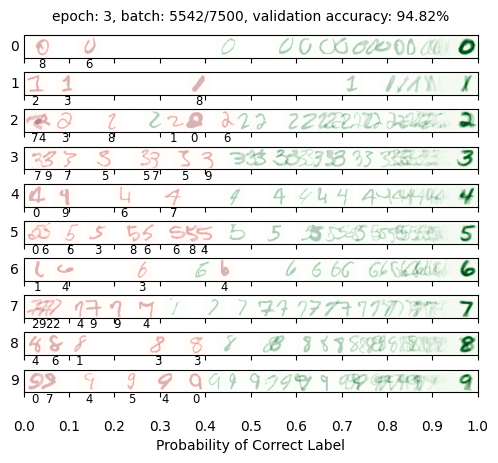

In [ ]:
model = DigitClassificationModel()
dataset = DigitClassificationDataset(model)
model.train(dataset)

## Final: Submission

Congratulations!

Please download this nodebook as a `.ipynb` file and upload to Canvas.